In [1]:
%run ./utils.ipynb

In [2]:
train_df = pd.read_csv('../output/train_df.csv')
train_df.head()

,ImageId,EP1,EP2,EP3,EP4
0,ccd94dc85_0.png,NaN,NaN,NaN,NaN
1,ccd94dc85_1.png,NaN,NaN,NaN,NaN
2,ccd94dc85_2.png,NaN,NaN,NaN,NaN
3,ccd94dc85_3.png,NaN,NaN,8640 38 8820 114 9000 190 9218 228 9474 228 97...,NaN
4,ff5c7f868_0.png,NaN,NaN,NaN,NaN


------------------------

**Load data:**
-------------------
* helper methods
* create dataset
* visualize example images

In [3]:
classes = []
for i, row in train_df.iterrows():
    tmp_classes = np.zeros(4)
    if type(row['EP1']) != float:
        tmp_classes[0] = 1
    if type(row['EP2']) != float:
        tmp_classes[1] = 1
    if type(row['EP3']) != float:
        tmp_classes[2] = 1
    if type(row['EP4']) != float:
        tmp_classes[3] = 1
    classes.append(tmp_classes)

train_df['class'] = classes
print(train_df.shape)
train_df.head()

(50272, 6)


,ImageId,EP1,EP2,EP3,EP4,class
0,ccd94dc85_0.png,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0]"
1,ccd94dc85_1.png,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0]"
2,ccd94dc85_2.png,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0]"
3,ccd94dc85_3.png,NaN,NaN,8640 38 8820 114 9000 190 9218 228 9474 228 97...,NaN,"[0.0, 0.0, 1.0, 0.0]"
4,ff5c7f868_0.png,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0]"


In [4]:
X = np.array(train_df['ImageId'].values.tolist())
y = np.array(train_df['class'].values.tolist())

mskf = MultilabelStratifiedShuffleSplit(n_splits=2, test_size=0.15)

for train_index, test_index in mskf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [    0     1     2 ... 50268 50270 50271] TEST: [    5     9    10 ... 50257 50267 50269]
TRAIN: [    0     3     4 ... 50269 50270 50271] TEST: [    1     2     5 ... 50250 50258 50266]


In [5]:
class SteelDataset(Dataset):
    def __init__(self, df, x_col, y_col, path):
        self.df = df
        self.x_col = x_col
        self.y_col = y_col
        self.path = path
        self.mean = np.array([0.485, 0.456, 0.406])
        self.std = np.array([0.229, 0.224, 0.225])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # load image
        im_name = self.df[self.x_col].iloc[idx]
        img_path = f"{self.path}/{im_name}"
        img = cv2.imread(img_path)
        
        # normalize image
        img = img.astype(np.float32) / 255.0
        img = img - self.mean
        img = img / self.std
        
        # augment image and mask
        hflip = random.random() < 0.5
        if hflip:
            img = np.fliplr(img).copy()
            
        vflip = random.random() < 0.5
        if vflip:
            img = np.flipud(img).copy()
            
        # convert to torch tensors
        img = torch.from_numpy(img)
        img = img.permute(2, 0, 1)
        
        #combine
        sample = {'image': img, 'classes': self.df[self.y_col].iloc[idx]}
        return sample

In [6]:
steel_dataset = SteelDataset(train_df, 'ImageId', 'class', train_path)

/opt/conda/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


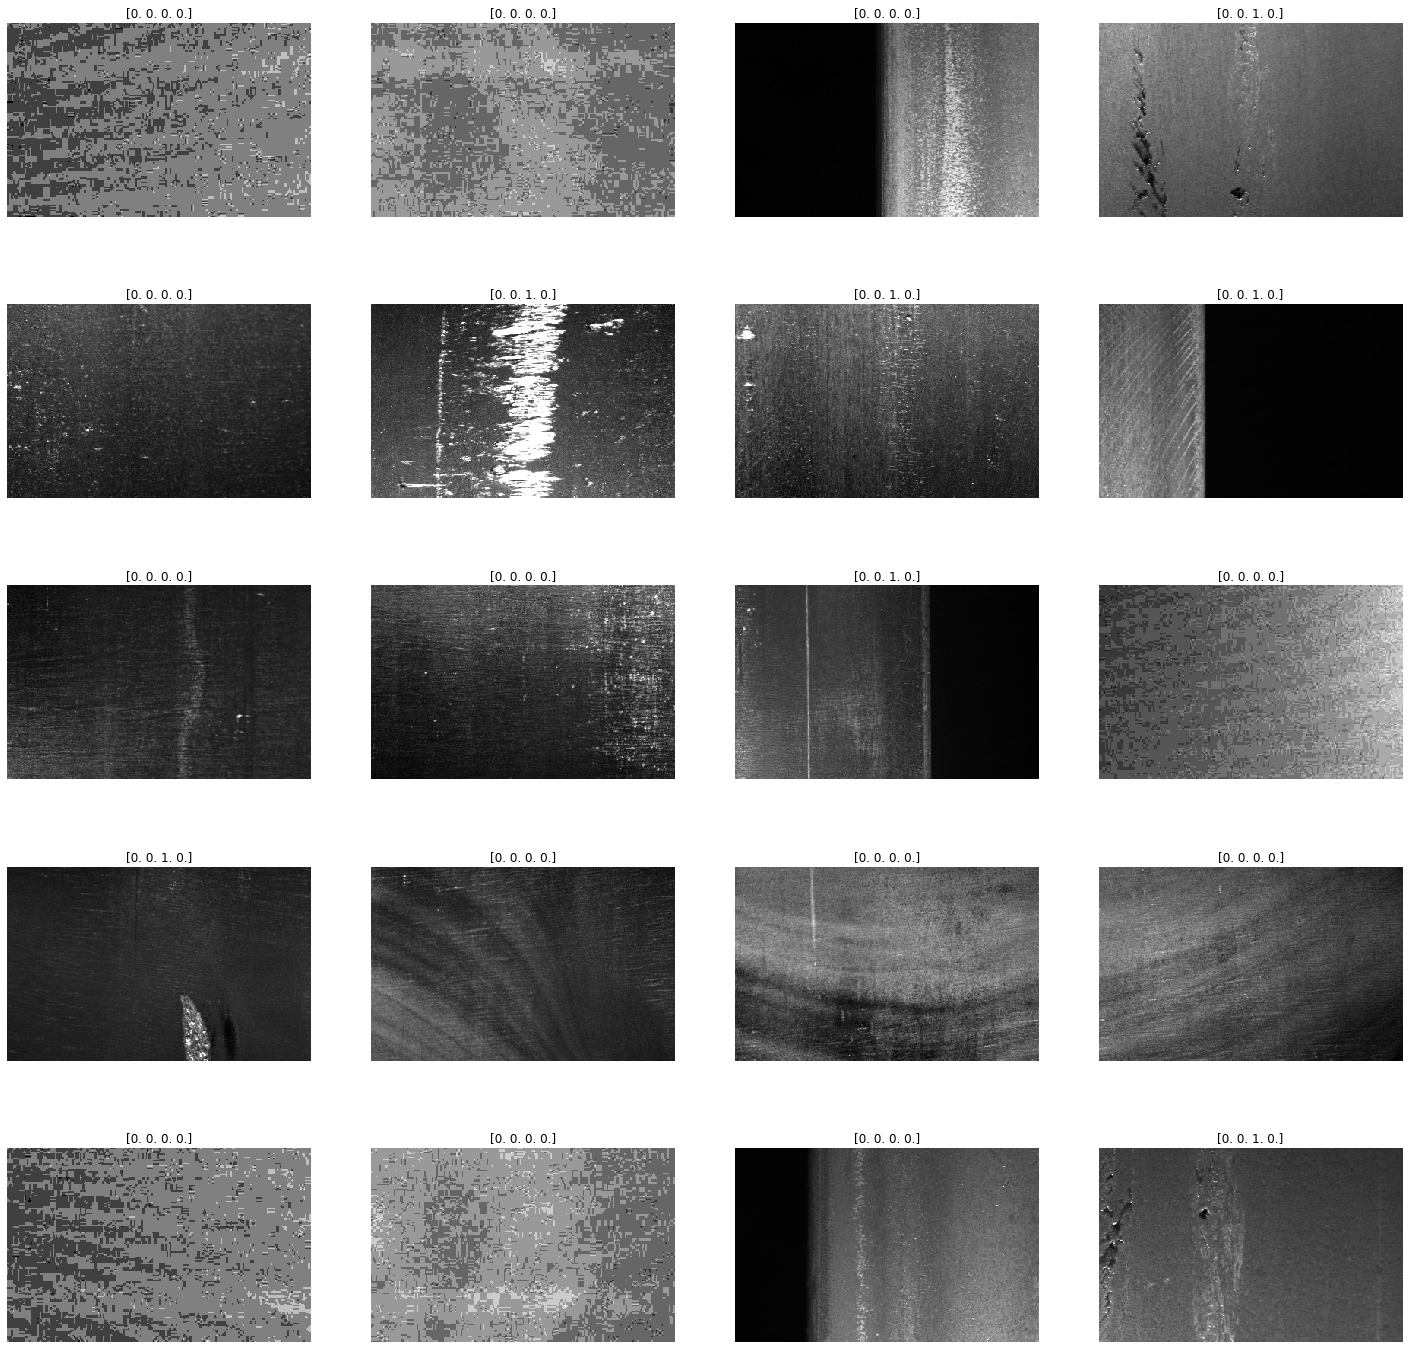

In [7]:
inc = 0
j = 0
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(25, 25), sharex=True)
for i in range(0,20,4):
    item1 = steel_dataset.__getitem__(i+inc)
    item2 = steel_dataset.__getitem__(i+inc+1)
    item3 = steel_dataset.__getitem__(i+inc+2)
    item4 = steel_dataset.__getitem__(i+inc+3)
    axs[j,0].set_title(item1['classes'])
    axs[j,0].imshow(item1['image'].permute(1, 2, 0)[:,:,0], cmap='gray')
    axs[j,0].axis('off')
    axs[j,1].set_title(item2['classes'])
    axs[j,1].imshow(item2['image'].permute(1, 2, 0)[:,:,0], cmap='gray')
    axs[j,1].axis('off')
    axs[j,2].set_title(item3['classes'])
    axs[j,2].imshow(item3['image'].permute(1, 2, 0)[:,:,0], cmap='gray')
    axs[j,2].axis('off')
    axs[j,3].set_title(item4['classes'])
    axs[j,3].imshow(item4['image'].permute(1, 2, 0)[:,:,0], cmap='gray')
    axs[j,3].axis('off')
    j+=1

In [8]:
# Parameters
params_train = {'batch_size': 64,
          'num_workers': 6}

params_val = {'batch_size': 64,
          'shuffle': False,
          'num_workers': 6}

train_dataset = SteelDataset(train_df.iloc[train_index], 'ImageId', 'class', train_path)
training_generator = DataLoader(train_dataset, pin_memory  = True, **params_train)

val_dataset = SteelDataset(train_df.iloc[test_index], 'ImageId', 'class', train_path)
validation_generator = DataLoader(val_dataset, pin_memory  = True, **params_val)

--------------------------

In [9]:
# Metric
def metric_hit(logit, truth, threshold=0.5):
    batch_size,num_class = logit.shape

    with torch.no_grad():
        logit = logit.view(batch_size,num_class,-1)
        truth = truth.view(batch_size,num_class,-1)

        probability = torch.sigmoid(logit)
        p = (probability>threshold).float()
        t = (truth>0.5).float()

        tp = ((p + t) == 2).float()  # True positives
        tn = ((p + t) == 0).float()  # True negatives

        tp = tp.sum(dim=[0,2])
        tn = tn.sum(dim=[0,2])
        num_pos = t.sum(dim=[0,2])
        num_neg = batch_size - num_pos

        tp = tp.data.cpu().numpy()
        tn = tn.data.cpu().numpy().sum()
        num_pos = num_pos.data.cpu().numpy()
        num_neg = num_neg.data.cpu().numpy().sum()

        tp = np.nan_to_num(tp/(num_pos+1e-12),0)
        tn = np.nan_to_num(tn/(num_neg+1e-12),0)

        tp = list(tp)
        num_pos = list(num_pos)

    return tn,tp,num_neg,num_pos

**Metrics:**
------------

In [10]:
def softmax_loss(logit, truth):
    logit = logit.view(-1)
    truth = truth.view(-1)
    loss = F.binary_cross_entropy_with_logits(logit, truth, reduction='none')

    if weight is None:
        loss = loss.mean()

    else:
        class_weight = class_weight/np.mean(class_weight)
        weight = weight/np.mean(weight)
        loss = loss*torch.Tensor(class_weight).cuda()
        pos = (truth>0.5).float() #[1,0,0,0,1,...]
        neg = (truth<0.5).float() #[0,1,1,1,0,...]
        pos_sum = pos.sum().item() + 1e-12 #2
        neg_sum = neg.sum().item() + 1e-12 #3
        loss = (weight[1]*pos*loss/pos_sum + weight[0]*neg*loss/neg_sum).mean()
        #raise NotImplementedError

    return loss

--------------------

**Create model:**
-------------------

In [11]:
class ArcFaceLoss(nn.modules.Module):
    def __init__(self,s=30.0,m=0.5):
        super(ArcFaceLoss, self).__init__()
        self.classify_loss = nn.BCEWithLogitsLoss()
        self.s = s
        self.easy_margin = False
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, logits, labels):
        logits = logits.view(-1).double()
        labels = labels.view(-1).double()
        cosine = logits
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        #one_hot = torch.zeros(cosine.size(), device='cuda')
        #one_hot.scatter_(1, labels.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (labels * phi) + ((1.0 - labels) * cosine)
        output *= self.s
        loss1 = self.classify_loss(output, labels)
        loss2 = self.classify_loss(cosine, labels)
        gamma=1
        loss=(loss1+gamma*loss2)/(1+gamma)
        return loss

In [12]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features):
        super(ArcMarginProduct, self).__init__()
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        # nn.init.xavier_uniform_(self.weight)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, features):
        cosine = F.linear(F.normalize(features), F.normalize(self.weight.cuda()))
        return cosine

In [13]:
class Net(nn.Module):

    def __init__(self, num_classes=4, EX=1):
        super(Net,self).__init__()
        self.EX = EX
        self.basemodel = torchvision.models.resnet34(pretrained=True)
        self.basemodel.avgpool = nn.AdaptiveAvgPool2d(1)
        self.basemodel.layer0 = nn.Sequential(self.basemodel.conv1,
                                              self.basemodel.bn1,
                                              self.basemodel.relu,
                                              self.basemodel.maxpool)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.arc_margin_product=ArcMarginProduct(512, num_classes)
        self.bn1 = nn.BatchNorm1d(1024 * self.EX)
        self.fc1 = nn.Linear(1024 * self.EX, 512 * self.EX)
        self.bn2 = nn.BatchNorm1d(512 * self.EX)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(512 * self.EX, 512)
        self.bn3 = nn.BatchNorm1d(512)

    def forward(self, x, extract_feature = False):
        # basemodel
        x = self.basemodel.layer0(x)
        x = self.basemodel.layer1(x)
        x = self.basemodel.layer2(x)
        x = self.basemodel.layer3(x)
        x = self.basemodel.layer4(x)
        # new head
        x = torch.cat((nn.AdaptiveAvgPool2d(1)(x), nn.AdaptiveMaxPool2d(1)(x)), dim=1)
        x = x.view(x.size(0), -1)
        x = self.bn1(x)
        x = F.dropout(x, p=0.25)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = F.dropout(x, p=0.5)

        x = x.view(x.size(0), -1)

        x = self.fc2(x)
        feature = self.bn3(x)

        cosine=self.arc_margin_product(feature)
        if extract_feature:
            return cosine, feature
        else:
            return cosine

-------------------

**Train:**
--------------

In [25]:
cudnn.benchmark = True

max_epochs = 50
base_lr = 0.03

criterion = ArcFaceLoss()

model = Net()

# group weight and config optimizer
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                                 lr=base_lr)
    
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

model.to(device)

Net(
  (basemodel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [26]:
def save_checkpoint(state, is_best, filename='../output/models/class_model2.pth'):
    # taken from https://blog.floydhub.com/checkpointing-tutorial-for-tensorflow-keras-and-pytorch/
    """Save checkpoint if a new best is achieved"""
    if is_best:
        print ("=> Saving a new best")
        torch.save(state, filename)  # save checkpoint
    else:
        print('\n')

In [27]:
def time_to_str(t, mode='min'):
    if mode=='min':
        t  = int(t)/60
        hr = t//60
        min = t%60
        return '%2d hr %02d min'%(hr,min)

    elif mode=='sec':
        t   = int(t)
        min = t//60
        sec = t%60
        return '%2d min %02d sec'%(min,sec)

    else:
        raise NotImplementedError

In [28]:
ckpt_path = "../output/models/class_model2.pth"
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])
model.to(device)

Net(
  (basemodel): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [29]:
print('rate     batch    epoch |  loss    tn, [tp1,tp2,tp3,tp4]       |  loss    tn, [tp1,tp2,tp3,tp4]       | time           ')
print('--------------------------------------------------------------------------------------------------------------------\n')
best_loss_set = False
start = timer()
model.train()
for epoch in range(max_epochs):
    running_loss_train = 0
    running_tn = 0
    running_tp = np.zeros(4)
    rate = get_lr(optimizer)
    
    for idx, minibatch in enumerate(training_generator):
        optimizer.zero_grad()

        imgs = minibatch['image'].float()
        labels = minibatch['classes']

        imgs = imgs.cuda()
        labels = labels.cuda()
        
        logits = model.forward(imgs, extract_feature = False)
        
        #print((labels, logits))
        loss = criterion(logits, labels)
        tn, tp, _, _ = metric_hit(logits, labels)
        
        running_loss_train += loss
        running_tn += tn
        running_tp = np.add(tp,running_tp)
        
        loss.backward()
        optimizer.step()
        
        print('\r',end='',flush=True)
        asterisk = ' '
        print('%0.5f  %5.1f%s %5.1f |  %5.3f   %4.2f [%4.2f,%4.2f,%4.2f,%4.2f]  | %s' % (\
                     rate, idx/len(training_generator), asterisk, epoch,
                     loss, tn, *tp[:6],
                     time_to_str((timer() - start),'min'))
        , end='',flush=True)
  
    with torch.set_grad_enabled(False):
        running_loss_val = 0
        running_tn_val = 0
        running_tp_val = np.zeros(4)
        
        loss_train = running_loss_train/len(training_generator)
        tn_train = running_tn/len(training_generator)
        tp_train = running_tp/len(training_generator)
        
        for idx, minibatch in enumerate(validation_generator):
            imgs = minibatch['image'].float()
            labels = minibatch['classes']

            imgs = imgs.cuda()
            labels = labels.cuda()

        
            logits = model.forward(imgs, extract_feature = False)

            loss = criterion(logits, labels)
            tn, tp, _, _ = metric_hit(logits, labels)

            running_loss_val += loss
            running_tn_val += tn
            running_tp_val = np.add(tp,running_tp_val)
            
            print('\r',end='',flush=True)
            asterisk = ' '
            print('%0.5f  %5.1f%s %5.1f |  %5.3f   %4.2f [%4.2f,%4.2f,%4.2f,%4.2f]  |  %5.3f   %4.2f [%4.2f,%4.2f,%4.2f,%4.2f]  | %s' % (\
                     rate, idx/len(validation_generator), asterisk, epoch,
                     loss_train, tn_train, *tp_train[:6],
                     loss, tn, *tp[:6],                                                                                                         
                     time_to_str((timer() - start),'min'))
            , end='',flush=True)


        val_loss = running_loss_val/len(validation_generator)
        tn_val = running_tn_val/len(validation_generator)
        tp_val = running_tp_val/len(validation_generator)
            

        print('\r',end='',flush=True)
        asterisk = ' '
        print('%0.5f  %5.1f%s %5.1f |  %5.3f   %4.2f [%4.2f,%4.2f,%4.2f,%4.2f]  |  %5.3f   %4.2f [%4.2f,%4.2f,%4.2f,%4.2f]  | %s' % (\
                 rate, idx/len(validation_generator), asterisk, epoch,
                 loss_train, tn_train, *tp_train[:6],
                 val_loss, tn_val, *tp_val[:6],                                                                                                         
                 time_to_str((timer() - start),'min'))
        )
                
        # Save checkpoint if is a new best
        if best_loss_set:
            is_best = bool(best_loss > val_loss)
            best_loss = min(val_loss, best_loss)
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_loss': best_loss
            }, is_best)
        else:
            best_loss = val_loss
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_loss': best_loss
            }, True)
            best_loss_set = True

        # Reduce LR on Plateau
        scheduler.step(loss)

rate     batch    epoch |  loss    tn, [tp1,tp2,tp3,tp4]       |  loss    tn, [tp1,tp2,tp3,tp4]       | time           
--------------------------------------------------------------------------------------------------------------------

0.03000    1.0    0.0 |  0.685   0.97 [0.08,0.00,0.73,0.04]  |  0.663   0.98 [0.02,0.00,0.72,0.16]  |  0 hr 07 min
=> Saving a new best
0.03000    1.0    1.0 |  0.661   0.97 [0.10,0.00,0.75,0.09]  |  0.629   0.98 [0.07,0.00,0.77,0.32]  |  0 hr 15 min
=> Saving a new best
0.03000    1.0    2.0 |  0.643   0.97 [0.12,0.00,0.78,0.13]  |  0.611   0.97 [0.10,0.00,0.78,0.36]  |  0 hr 23 min
=> Saving a new best
0.03000    1.0    3.0 |  0.628   0.97 [0.13,0.00,0.79,0.19]  |  0.607   0.98 [0.11,0.00,0.76,0.46]  |  0 hr 31 min
=> Saving a new best
0.03000    1.0    4.0 |  0.615   0.97 [0.17,0.01,0.80,0.23]  |  0.597   0.97 [0.13,0.00,0.79,0.45]  |  0 hr 38 min
=> Saving a new best
0.03000    1.0    5.0 |  0.619   0.97 [0.18,0.01,0.79,0.25]  |  0.644   0.97 [0.11